In [1]:
import numpy as np
import pandas as pd
import os
import rasterio
import imageio
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import mxnet as mx
from mxnet import gluon
from mxnet import autograd
from mxnet import image
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../../resuneta/src')
sys.path.append('../../resuneta/nn/loss')
sys.path.append('../../resuneta/models')
sys.path.append('../../')

from bound_dist import get_distance, get_boundary
from loss import Tanimoto_wth_dual
from resunet_d6_causal_mtskcolor_ddist import *
from resunet_d7_causal_mtskcolor_ddist import *

# Dataset

In [188]:
class PlanetDataset(gluon.data.Dataset):
    
    def __init__(self, image_directory, label_directory, image_names=None,
                 image_suffix='.jpeg', label_suffix='.png'):
        self.image_directory = image_directory
        self.label_directory = label_directory
        
        self.image_suffix = image_suffix
        self.label_suffix = label_suffix
        
        if image_names is None:
            image_names = os.listdir(image_directory)
            self.image_names = [x.split('.')[0] for x in image_names]
        else:
            self.image_names = image_names
        
    def __getitem__(self, item):
        image_path = os.path.join(self.image_directory, 
                                  str(self.image_names[item]) + self.image_suffix)
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        # TODO: change this
        image = image[:256, :256]
        
        extent_path = os.path.join(self.label_directory, 
                                   str(self.image_names[item]) + self.label_suffix)
        extent_mask = imageio.imread(extent_path)
        # TODO: change this
        extent_mask = extent_mask[:256, :256] / 255
        
        # brightness augmentation
        image = np.minimum(
            np.random.uniform(low=0.9, high=1.1) * image, 255).astype(np.uint8)
        
        # rotation augmentation
        k = np.random.randint(low=0, high=4)
        image = np.rot90(image, k, axes=(0,1))
        extent_mask = np.rot90(extent_mask, k, axes=(0,1))
        
        # flip augmentation
        if np.random.uniform() > 0.5:
            image = np.flip(image, axis=0)
            extent_mask = np.flip(extent_mask, axis=0)
        if np.random.uniform() > 0.5:
            image = np.flip(image, axis=1)
            extent_mask = np.flip(extent_mask, axis=1)
        
        boundary_mask = get_boundary(extent_mask)
        distance_mask = get_distance(extent_mask)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        image = mx.nd.array(np.moveaxis(image, -1, 0))
        image_hsv = mx.nd.array(np.moveaxis(image_hsv, -1, 0)) / 255.
        
        extent_mask = mx.nd.array(np.expand_dims(extent_mask, 0))
        boundary_mask = mx.nd.array(np.expand_dims(boundary_mask, 0))
        distance_mask = mx.nd.array(np.expand_dims(distance_mask, 0))
        
        return image, extent_mask, boundary_mask, distance_mask, image_hsv
    
    def __len__(self):
        return len(self.image_names)

In [184]:
# class PlanetDataset(gluon.data.Dataset):
    
#     def __init__(self, image_directory, label_directory, image_names=None,
#                  image_suffix='.jpeg', label_suffix='.png'):
#         self.image_directory = image_directory
#         self.label_directory = label_directory
        
#         self.image_suffix = image_suffix
#         self.label_suffix = label_suffix
        
#         if image_names is None:
#             image_names = os.listdir(image_directory)
#             self.image_names = [x.split('.')[0] for x in image_names]
#         else:
#             self.image_names = image_names
        
#     def __getitem__(self, item):
#         image_path = os.path.join(self.image_directory, 
#                                   str(self.image_names[item]) + self.image_suffix)
#         image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
#         print("image",image)
#         plt.imshow(image)
#         plt.show()
        
#         extent_path = os.path.join(self.label_directory, 
#                                    str(self.image_names[item]) + self.label_suffix)
#         extent_mask = imageio.imread(extent_path) / 255
        
#         # brightness augmentation
#         image = np.minimum(
#             np.random.uniform(low=0.9, high=1.1) * image, 255).astype(np.uint8)
#         print("image2",image)
#         plt.imshow(image)
#         plt.show()
        
#         # rotation augmentation
#         k = np.random.randint(low=0, high=4)
#         image = np.rot90(image, k, axes=(0,1))
#         extent_mask = np.rot90(extent_mask, k, axes=(0,1))
        
#         boundary_mask = get_boundary(extent_mask)
#         distance_mask = get_distance(extent_mask)
        
#         # rest of data augmentation
#         concat = np.concatenate([image, np.expand_dims(extent_mask, -1), 
#                                  np.expand_dims(boundary_mask, -1), 
#                                  np.expand_dims(distance_mask, -1)], axis=-1)
#         concat = mx.nd.array(concat)
#         augmented = augment(concat)
#         image = augmented[:,:,:3].asnumpy()
#         extent_mask = mx.nd.expand_dims(augmented[:,:,3], axis=0)
#         boundary_mask = mx.nd.expand_dims(augmented[:,:,4], axis=0)
#         distance_mask = mx.nd.expand_dims(augmented[:,:,5], axis=0)
#         image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#         image = np.moveaxis(image, -1, 0)
#         image = mx.nd.array(image)
#         image_hsv = mx.nd.array(np.moveaxis(image_hsv, -1, 0)) / 255.
        
#         return image, extent_mask, boundary_mask, distance_mask, image_hsv
    
#     def __len__(self):
#         return len(self.image_names)


In [185]:
# def augment(concat):
#     concat, crop_box = mx.image.random_crop(concat, size=(256, 256))
# #     concat = mx.image.random_rotate(concat, (0, 360)) # not available in 1.6.0
    
#     hflip = mx.image.HorizontalFlipAug(0.5)
#     concat = hflip(concat)
    
#     if np.random.uniform() > 0.5: # manual vertical flip
#         concat = mx.ndarray.flip(concat, axis=0)
    
#     return concat

# Dataloader

In [186]:
image_directory = '../data/planet/france/april/'
label_directory = '../data/planet/france/labels/'

# all_names = os.listdir(image_directory)
# all_names = [x.split('.')[0] for x in all_names]
# trainval_names, test_names = train_test_split(all_names, test_size=0.2)
# train_names, val_names = train_test_split(trainval_names, test_size=0.2)

# Load train/val/test splits
splits_df = pd.read_csv('../data/splits/hanAndBurak_planetImagery_splits.csv')
train_names = splits_df[splits_df['fold'] == 'train']['image_id'].values
val_names = splits_df[splits_df['fold'] == 'val']['image_id'].values
test_names = splits_df[splits_df['fold'] == 'test']['image_id'].values

train_dataset = PlanetDataset(image_directory, label_directory, image_names=train_names)
val_dataset = PlanetDataset(image_directory, label_directory, image_names=val_names)
test_dataset = PlanetDataset(image_directory, label_directory, image_names=test_names)

image [[[ 61  72  42]
  [ 62  72  45]
  [ 64  74  47]
  ...
  [ 99  92  64]
  [103  93  66]
  [106  92  66]]

 [[ 56  69  41]
  [ 58  71  43]
  [ 60  73  45]
  ...
  [ 98  92  66]
  [100  93  67]
  [101  91  64]]

 [[ 57  70  40]
  [ 57  70  42]
  [ 59  72  46]
  ...
  [ 85  81  56]
  [ 91  85  61]
  [ 94  88  62]]

 ...

 [[191 156 118]
  [188 154 116]
  [190 156 119]
  ...
  [ 86  82  53]
  [114 105  74]
  [133 118  85]]

 [[188 153 113]
  [186 153 112]
  [188 154 116]
  ...
  [ 68  67  39]
  [ 99  92  63]
  [128 115  83]]

 [[191 156 114]
  [192 157 117]
  [190 156 118]
  ...
  [ 59  62  35]
  [ 85  82  51]
  [122 113  80]]]


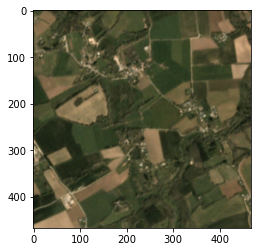

image2 [[[ 57  68  39]
  [ 58  68  42]
  [ 60  70  44]
  ...
  [ 93  87  60]
  [ 97  88  62]
  [100  87  62]]

 [[ 53  65  38]
  [ 55  67  40]
  [ 56  69  42]
  ...
  [ 93  87  62]
  [ 94  88  63]
  [ 95  86  60]]

 [[ 54  66  37]
  [ 54  66  39]
  [ 56  68  43]
  ...
  [ 80  76  53]
  [ 86  80  57]
  [ 89  83  58]]

 ...

 [[181 148 112]
  [178 146 110]
  [180 148 112]
  ...
  [ 81  77  50]
  [108  99  70]
  [126 112  80]]

 [[178 145 107]
  [176 145 106]
  [178 146 110]
  ...
  [ 64  63  37]
  [ 93  87  59]
  [121 109  78]]

 [[181 148 108]
  [182 149 111]
  [180 148 112]
  ...
  [ 56  58  33]
  [ 80  77  48]
  [115 107  75]]]


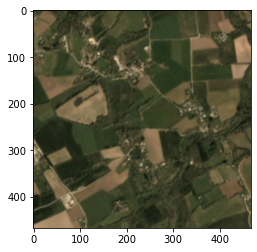

image [[[131 110  79]
  [127 107  74]
  [126 106  71]
  ...
  [153 131  92]
  [150 132  96]
  [141 125  91]]

 [[134 114  81]
  [132 109  77]
  [131 108  76]
  ...
  [147 125  86]
  [146 126  89]
  [145 126  93]]

 [[137 117  82]
  [135 112  80]
  [137 114  82]
  ...
  [141 119  78]
  [136 116  79]
  [137 121  85]]

 ...

 [[ 73  67  35]
  [ 63  59  30]
  [ 65  65  39]
  ...
  [104  90  61]
  [107  92  61]
  [110  94  61]]

 [[ 75  66  35]
  [ 64  59  30]
  [ 62  62  36]
  ...
  [ 96  87  56]
  [102  89  57]
  [105  90  57]]

 [[ 75  66  35]
  [ 65  60  31]
  [ 58  58  32]
  ...
  [ 88  81  52]
  [ 94  83  53]
  [ 99  86  54]]]


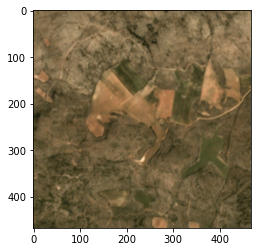

image2 [[[118  99  71]
  [115  97  67]
  [114  96  64]
  ...
  [138 118  83]
  [135 119  87]
  [127 113  82]]

 [[121 103  73]
  [119  98  69]
  [118  97  68]
  ...
  [133 113  77]
  [132 114  80]
  [131 114  84]]

 [[124 106  74]
  [122 101  72]
  [124 103  74]
  ...
  [127 107  70]
  [123 105  71]
  [124 109  77]]

 ...

 [[ 66  60  31]
  [ 57  53  27]
  [ 58  58  35]
  ...
  [ 94  81  55]
  [ 97  83  55]
  [ 99  85  55]]

 [[ 67  59  31]
  [ 58  53  27]
  [ 56  56  32]
  ...
  [ 87  78  50]
  [ 92  80  51]
  [ 95  81  51]]

 [[ 67  59  31]
  [ 58  54  28]
  [ 52  52  29]
  ...
  [ 79  73  47]
  [ 85  75  48]
  [ 89  77  48]]]


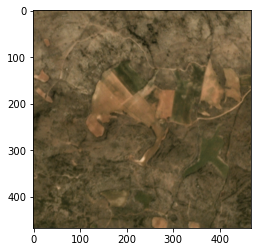

image [[[ 67  70  41]
  [ 77  76  46]
  [ 95  90  61]
  ...
  [ 83  75  52]
  [ 76  69  43]
  [ 78  71  45]]

 [[ 76  77  46]
  [ 90  85  55]
  [111 100  72]
  ...
  [ 84  76  53]
  [ 76  68  45]
  [ 76  69  43]]

 [[ 90  85  53]
  [112  98  69]
  [132 112  85]
  ...
  [ 80  72  49]
  [ 77  69  46]
  [ 79  72  46]]

 ...

 [[ 42  47  24]
  [ 42  48  22]
  [ 41  50  23]
  ...
  [139 109  73]
  [125 100  69]
  [111  91  64]]

 [[ 62  58  29]
  [ 56  55  25]
  [ 49  52  21]
  ...
  [150 117  84]
  [132 105  75]
  [110  89  62]]

 [[ 87  77  42]
  [ 76  68  32]
  [ 62  59  24]
  ...
  [160 125  93]
  [139 112  83]
  [108  86  62]]]


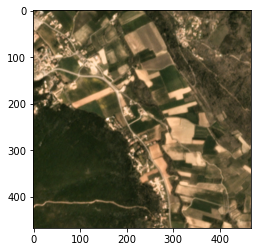

image2 [[[ 60  63  36]
  [ 69  68  41]
  [ 85  81  55]
  ...
  [ 74  67  46]
  [ 68  62  38]
  [ 70  64  40]]

 [[ 68  69  41]
  [ 81  76  49]
  [100  90  64]
  ...
  [ 75  68  47]
  [ 68  61  40]
  [ 68  62  38]]

 [[ 81  76  47]
  [101  88  62]
  [119 101  76]
  ...
  [ 72  64  44]
  [ 69  62  41]
  [ 71  64  41]]

 ...

 [[ 37  42  21]
  [ 37  43  19]
  [ 36  45  20]
  ...
  [125  98  65]
  [112  90  62]
  [100  82  57]]

 [[ 55  52  26]
  [ 50  49  22]
  [ 44  46  18]
  ...
  [135 105  75]
  [119  94  67]
  [ 99  80  55]]

 [[ 78  69  37]
  [ 68  61  28]
  [ 55  53  21]
  ...
  [144 112  83]
  [125 101  74]
  [ 97  77  55]]]


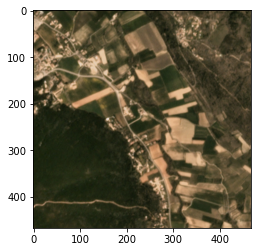

image [[[129 115  88]
  [147 132 101]
  [152 132  97]
  ...
  [121 106  73]
  [118 103  72]
  [128 113  82]]

 [[139 120  90]
  [151 132  99]
  [150 128  89]
  ...
  [105  90  57]
  [101  86  53]
  [112  97  64]]

 [[144 121  89]
  [158 136  99]
  [153 130  88]
  ...
  [109  93  59]
  [105  89  55]
  [114  95  62]]

 ...

 [[183 137 103]
  [179 135 100]
  [176 131  98]
  ...
  [134 105  75]
  [119  94  64]
  [114  90  64]]

 [[184 138 102]
  [183 139 104]
  [181 137 102]
  ...
  [131 105  72]
  [119  96  65]
  [113  92  63]]

 [[184 138 102]
  [183 139 102]
  [182 138 103]
  ...
  [128 104  70]
  [119  96  64]
  [112  93  63]]]


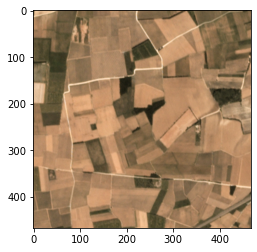

image2 [[[124 111  85]
  [142 127  97]
  [146 127  93]
  ...
  [116 102  70]
  [114  99  69]
  [123 109  79]]

 [[134 115  86]
  [145 127  95]
  [144 123  85]
  ...
  [101  86  55]
  [ 97  83  51]
  [108  93  61]]

 [[139 116  85]
  [152 131  95]
  [147 125  85]
  ...
  [105  89  57]
  [101  85  53]
  [110  91  59]]

 ...

 [[176 132  99]
  [172 130  96]
  [170 126  94]
  ...
  [129 101  72]
  [114  90  61]
  [110  86  61]]

 [[177 133  98]
  [176 134 100]
  [174 132  98]
  ...
  [126 101  69]
  [114  92  62]
  [109  88  60]]

 [[177 133  98]
  [176 134  98]
  [175 133  99]
  ...
  [123 100  67]
  [114  92  61]
  [108  89  60]]]


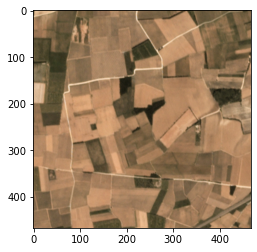

img_batch has shape (4, 3, 256, 256)
extent_batch has shape (4, 1, 256, 256)


In [187]:
batch_size = 4
train_dataloader = gluon.data.DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = gluon.data.DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = gluon.data.DataLoader(test_dataset, batch_size=batch_size)

for img_batch, extent_batch, boundary_batch, distance_batch, hsv_batch in train_dataloader:
    print("img_batch has shape {}".format(img_batch.shape))
    print("extent_batch has shape {}".format(extent_batch.shape))
    
    break

In [5]:
img_batch.size

786432

# Training loop

In [16]:
def train_model(train_dataloader, model, tanimoto_dual, trainer, epoch):
    
    # initialize metrics
    cumulative_loss = 0
    accuracy = mx.metric.Accuracy()
    f1 = mx.metric.F1()
    mcc = mx.metric.MCC()
    
    # training set
    for batch_i, (img, extent, boundary, distance, hsv) in enumerate(
        tqdm(train_dataloader, desc='Training epoch {}'.format(epoch))):
        
        with autograd.record():

            img = img.as_in_context(mx.gpu())
            extent = extent.as_in_context(mx.gpu())
            boundary = boundary.as_in_context(mx.gpu())
            distance = distance.as_in_context(mx.gpu())
            hsv = hsv.as_in_context(mx.gpu())
            
            logits, bound, dist, convc = model(img)
            
            # multi-task loss
            # TODO: wrap this in a custom loss function / class
            loss_extent = mx.nd.sum(1 - tanimoto_dual(logits, extent))
            loss_boundary = mx.nd.sum(1 - tanimoto_dual(bound, boundary))
            loss_distance = mx.nd.sum(1 - tanimoto_dual(dist, distance))
            loss_hsv = mx.nd.sum(1 - tanimoto_dual(convc, hsv))
            
            loss = 0.25 * (loss_extent + loss_boundary + loss_distance + loss_hsv)
            
        loss.backward()
        trainer.step(batch_size)
        
        # update metrics based on every batch
        cumulative_loss += mx.nd.sum(loss).asscalar()
        # accuracy
        extent_predicted_classes = mx.nd.ceil(logits[:,[0],:,:] - 0.5)
        accuracy.update(extent, extent_predicted_classes)
        # f1 score
        prediction = logits[:,0,:,:].reshape(-1)
        probabilities = mx.nd.stack(1 - prediction, prediction, axis=1)
        f1.update(extent.reshape(-1), probabilities)
        # MCC metric
        mcc.update(extent.reshape(-1), probabilities)
        # TODO: eccentricity
        # TODO: ...
        
    return cumulative_loss, accuracy, f1, mcc

In [17]:
def evaluate_model(val_dataloader, model, tanimoto_dual, epoch):
    
    # initialize metrics
    cumulative_loss = 0
    accuracy = mx.metric.Accuracy()
    f1 = mx.metric.F1()
    mcc = mx.metric.MCC()
    
    # validation set
    for batch_i, (img, extent, boundary, distance, hsv) in enumerate(
        tqdm(val_dataloader, desc='Validation epoch {}'.format(epoch))):

        img = img.as_in_context(mx.gpu())
        extent = extent.as_in_context(mx.gpu())
        boundary = boundary.as_in_context(mx.gpu())
        distance = distance.as_in_context(mx.gpu())
        hsv = hsv.as_in_context(mx.gpu())

        logits, bound, dist, convc = model(img)
            
        # multi-task loss
        # TODO: wrap this in a custom loss function / class
        loss_extent = mx.nd.sum(1 - tanimoto_dual(logits, extent))
        loss_boundary = mx.nd.sum(1 - tanimoto_dual(bound, boundary))
        loss_distance = mx.nd.sum(1 - tanimoto_dual(dist, distance))
        loss_hsv = mx.nd.sum(1 - tanimoto_dual(convc, hsv))

        loss = 0.25 * (loss_extent + loss_boundary + loss_distance + loss_hsv)
        
        # update metrics based on every batch
        cumulative_loss += mx.nd.sum(loss).asscalar()
        # accuracy
        extent_predicted_classes = mx.nd.ceil(logits[:,[0],:,:] - 0.5)
        accuracy.update(extent, extent_predicted_classes)
        # f1 score
        prediction = logits[:,0,:,:].reshape(-1)
        probabilities = mx.nd.stack(1 - prediction, prediction, axis=1)
        f1.update(extent.reshape(-1), probabilities)
        # MCC metric
        mcc.update(extent.reshape(-1), probabilities)
        # TODO: eccentricity
        # TODO: ...
        
    return cumulative_loss, accuracy, f1, mcc

In [6]:
# hyperparameters
lr = 0.001
epochs = 2
batch_size = 4
save_path = '../experiments/france/'
save_file_name = os.path.join(save_path, "model_2k.params")
n_filters = 8
n_classes = 2

# define model
model = ResUNet_d6(_nfilters_init=n_filters, _NClasses=n_classes)
model.initialize()
model.hybridize()
model.collect_params().reset_ctx(mx.gpu())

# define loss function
tanimoto_dual = Tanimoto_wth_dual()
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(model.collect_params(),
                        'adam', {'learning_rate': lr})

# containers for metrics to log
train_metrics = {'train_loss': [], 'train_acc': [], 'train_f1': [], 
                 'train_mcc': []}
val_metrics = {'val_loss': [], 'val_acc': [], 'val_f1': [], 
               'val_mcc': []}
best_mcc = 0.0

# training loop
for epoch in range(1, epochs+1):
    break
    
    # training set
    train_loss, train_accuracy, train_f1, train_mcc = train_model(
        train_dataloader, model, tanimoto_dual, trainer, epoch)
        
    # training set metrics
    train_loss_avg = train_loss / len(train_dataset)
    train_metrics['train_loss'].append(train_loss_avg)
    train_metrics['train_acc'].append(train_accuracy.get()[1])
    train_metrics['train_f1'].append(train_f1.get()[1])
    train_metrics['train_mcc'].append(train_mcc.get()[1])
    
    # validation set
    val_loss, val_accuracy, val_f1, val_mcc = evaluate_model(
        val_dataloader, model, tanimoto_dual, epoch)
    
    # validation set metrics
    val_loss_avg = val_loss / len(val_dataset)
    val_metrics['val_loss'].append(val_loss_avg)
    val_metrics['val_acc'].append(val_accuracy.get()[1])
    val_metrics['val_f1'].append(val_f1.get()[1])
    val_metrics['val_mcc'].append(val_mcc.get()[1])
    
    print("Epoch {}:".format(epoch))
    print("    Train loss {:0.3f}, accuracy {:0.3f}, F1-score {:0.3f}, MCC: {:0.3f}".format(
        train_loss_avg, train_accuracy.get()[1], train_f1.get()[1], train_mcc.get()[1]))
    print("    Val loss {:0.3f}, accuracy {:0.3f}, F1-score {:0.3f}, MCC: {:0.3f}".format(
        val_loss_avg, val_accuracy.get()[1], val_f1.get()[1], val_mcc.get()[1]))
    
    # save model based on best MCC metric
    if val_mcc.get()[1] > best_mcc:
        model.save_parameters(save_file_name)
        best_mcc = val_mcc.get()[1]

depth:= 0, nfilters: 8
depth:= 1, nfilters: 16
depth:= 2, nfilters: 32
depth:= 3, nfilters: 64
depth:= 4, nfilters: 128
depth:= 5, nfilters: 256
depth:= 6, nfilters: 128
depth:= 7, nfilters: 64
depth:= 8, nfilters: 32
depth:= 9, nfilters: 16
depth:= 10, nfilters: 8


In [7]:
logits, bound, dist, convc = model(img_batch.as_in_context(mx.gpu()))

In [28]:
img = cv2.imread('../data/planet/france/april/10003002.jpeg')

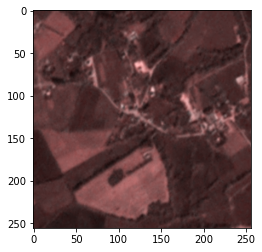

In [64]:
plt.imshow(cv2.cvtColor(np.moveaxis(hsv_batch[0].asnumpy()/255, 0, -1), cv2.COLOR_HSV2RGB))
plt.show()

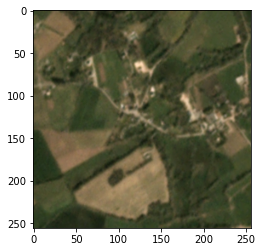

In [65]:
plt.imshow(cv2.cvtColor(np.moveaxis(hsv_batch[0].asnumpy().astype(np.uint8), 0, -1), cv2.COLOR_HSV2RGB))
plt.show()

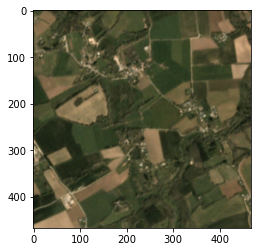

In [60]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

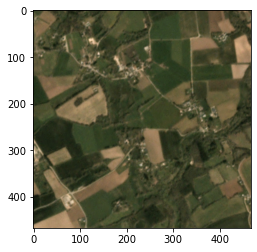

In [58]:
plt.imshow(cv2.cvtColor(cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cv2.COLOR_RGB2HSV), cv2.COLOR_HSV2RGB))
plt.show()

In [ ]:
#             img = img.astype('float32')
#             extent = extent.astype('float32')
#             boundary = boundary.astype('float32')
#             distance = distance.astype('float32')
#             hsv = hsv.astype('float32')

In [8]:
np.arange(1, 4).shape

(3,)

In [13]:
np.stack([[5,4,3], [7,6,5]], axis=1).shape

(3, 2)

In [13]:
np.tile(extent_batch.asnumpy()[0], (3,1,1)).shape

(3, 256, 256)

In [19]:
import visdom
visdom.__version__

'0.1.8.9'

In [20]:
print(dir(visdom))

['BS4_AVAILABLE', 'BytesIO', 'Image', 'Sequence', 'Visdom', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_assert_opts', '_axisformat', '_axisformat3d', '_dashCheck', '_lineColorCheck', '_markerColorCheck', '_opts2layout', '_scrub_dict', '_title2str', '_to_numpy', 'absolute_import', 'b64', 'base64', 'bs4', 'division', 'do_tsne', 'errno', 'from_t7', 'get_rand_id', 'hashlib', 'here', 'io', 'isndarray', 'isnum', 'isstr', 'json', 'loadfile', 'logger', 'logging', 'math', 'nan2none', 'np', 'numbers', 'os', 'print_function', 'pytorch_wrap', 're', 'requests', 'six', 'string_types', 'threading', 'time', 'torch_types', 'torchfile', 'traceback', 'unicode_literals', 'urllib', 'urlparse', 'urlunparse', 'version_file', 'warnings', 'websocket', 'wraps']


In [21]:
vis = visdom.Visdom(port=8097, env='testing_in_notebook')

Setting up a new session...
